# Text classification of podcast data
We take the transcripts of 70 one-hour episodes of the podcast *My Brother, My Brother and Me* and build a text-classification machine-learning model to predict which of the three podcast hosts said a particular piece of text.

The Python file *get_text.py* decribes how we processed the transcripts to obtain clean, usable textual data. We used the package `textract` to "read" through the transcript PDFs, and then with the help of the NLP library `nltk`, we were able to clean the text data to our specifications, and export to a csv.

For this project, our initial dataset is a csv file with each column corresponding to a brother — Griffin, Travis, or Justin — and each cell under that, a "line" that they said.

## 1. Data preprocessing and organization
### 1.1 Creating the feature matrix and target array
We import the relevant packages, as well as the dataset. 

We're looking to get a DataFrame that contains each line said, labeled by the speaker of the line. For this, we simply add a column specifying the person saying a line — do this for each speaker — and then use the function `pd.concat()` to combine them.

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set() #set Seaborn style

In [2]:
filename = r"C:\Users\arnav\OneDrive - OnTheHub - The University of Oxford\Documents\Coding, Summer 2020\McElroy Code\Datasets\lines_70.csv"

#Read CSV with speakers and words
df = pd.read_csv(filename)

In [3]:
#Create df with lines and speaker label
df_j = pd.DataFrame(df["justin"]).dropna()
df_j.rename(columns={"justin": "Line"}, inplace=True)
df_j["Speaker"] = "Justin" #add column with speaker name

df_j.head() #view format of imported data

,Line,Speaker
0,hello everyone and welcome to my brother my b...,Justin
1,an advice show for the modern era im your olde...,Justin
2,yeah i hear hes the blonde one that drives al...,Justin
3,bad fake laugh,Justin
4,glass watch,Justin


In [4]:
#Do for the other two as well

df_t = pd.DataFrame(df["travis"]).dropna()
df_t = df_t.rename(columns={"travis": "Line"})
df_t["Speaker"] = "Travis"

df_g = pd.DataFrame(df["griffin"]).dropna()
df_g = df_g.rename(columns={"griffin": "Line"})
df_g["Speaker"] = "Griffin"

In [5]:
#Combine {line: speaker} DataFrames
#This is the main DataFrame we'll use

lines_df = pd.concat([df_j, df_t, df_g], axis=0, ignore_index=True)
lines_df

,Line,Speaker
0,hello everyone and welcome to my brother my b...,Justin
1,an advice show for the modern era im your olde...,Justin
2,yeah i hear hes the blonde one that drives al...,Justin
3,bad fake laugh,Justin
4,glass watch,Justin
...,...,...
87641,okay laughs,Griffin
87642,i do have a final yahoo this one was sent in ...,Griffin
87643,its from yahoo answers user gaga who asks can...,Griffin
87644,radiohead 2,Griffin


### 1.2 Is the dataset balanced?
From analysis of the raw data — as done in *McElroy Analysis.ipynb* — we know that Justin speaks the most (he also introduces and ends the show), and Travis speaks the least. This isn't ideal for our prediction model: if the difference is large, the the model could just get a high accuracy by always predicting "Justin", which obviously isn't a very good model.

So, we first get an idea of how balanced/unbalanced the dataset is, by plotting the number of lines each speaker says.

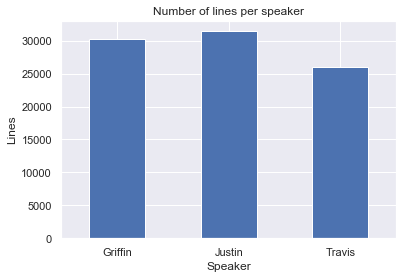

Speaker
Griffin    30285
Justin     31429
Travis     25932
Name: Line, dtype: int64

In [6]:
#Check how balanced the dataset is
lines_df.groupby("Speaker").Line.count().plot.bar(ylim=0)
plt.title("Number of lines per speaker")
plt.ylabel("Lines")
plt.xticks(rotation=0)
plt.show()

lines_df.groupby("Speaker").Line.count()

As we can see, Justin clearly speaks the most, and Travis speaks the least. (These are the "lines" spoken by each — the discrepancy in words spoken is even larger! This is explored more deeply in the data-analysis notebook.) 

A skewed dataset like this is not the best foundation for our model. What can we do to fix it?

One way to go about it is to only pick strings above a certain length when creating `lines_df`, and then accordingly allowing more "leeway" for Travis and Griffin. This can then allow us to manually modify the amount of text we pick from each speaker.

This also had the added advantage of removing extremely short strings that were constantly being misclassified (because any one of them could have said something short like "yeah" or "sure"). This was something I noticed on the first run-through of the model. Most of the misclassifications were single-word lines, which obviously weren't "unique" to any one of the speakers. This helped improve accuracy, as we'll see later.

In [7]:
df_j = pd.DataFrame(df["justin"]).dropna()
df_j = df_j.loc[df["justin"].str.len() > 30] #only pick strings above a certain length
df_j.rename(columns={"justin": "Line"}, inplace=True)
df_j["Speaker"] = "Justin" #add column with speaker name

df_t = pd.DataFrame(df["travis"]).dropna()
df_t = df_t.loc[df["travis"].str.len() > 10] #choose minimum length of string for Travis
df_t = df_t.rename(columns={"travis": "Line"})
df_t["Speaker"] = "Travis"

df_g = pd.DataFrame(df["griffin"]).dropna()
df_g = df_g.loc[df["griffin"].str.len() > 21] #choose minimum length of string for Griffin
df_g = df_g.rename(columns={"griffin": "Line"})
df_g["Speaker"] = "Griffin"

In [8]:
#Combine {line: speaker} DataFrames
#This is the main DataFrame we'll use

lines_df = pd.concat([df_j, df_t, df_g], axis=0, ignore_index=True)
lines_df

,Line,Speaker
0,hello everyone and welcome to my brother my b...,Justin
1,an advice show for the modern era im your olde...,Justin
2,yeah i hear hes the blonde one that drives al...,Justin
3,mr shyamalan is back with his bold vision,Justin
4,his marvel cinematic universe which is i have...,Justin
...,...,...
60582,shit that comes out soon huh,Griffin
60583,fuck we should finish it,Griffin
60584,we should probablyyeah,Griffin
60585,i do have a final yahoo this one was sent in ...,Griffin


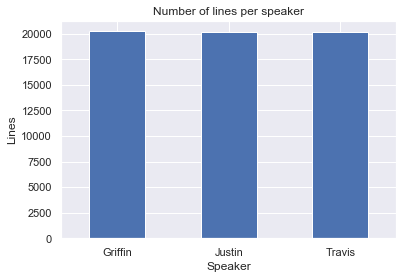

Speaker
Griffin    20242
Justin     20136
Travis     20209
Name: Line, dtype: int64

In [9]:
#Check how balanced the dataset is
lines_df.groupby("Speaker").Line.count().plot.bar()
plt.title("Number of lines per speaker")
plt.ylabel("Lines")
plt.xticks(rotation=0)
plt.show()

lines_df.groupby("Speaker").Line.count()

As we can see, the dataset now looks a lot more balanced! This was obviously a slightly more trial-and-error way of fixing the imbalance, but it also had the added bonus of removing extremely short strings.

## 2. Initial machine-learning model

### 2.1 Data splitting and shuffling
We start by splitting our data into training and test sets.

Here, `X` is the feature matrix, and contains all the strings of lines said by someone. We'll make it more usable, by running it through a Term Frequency–Inverse Document Frequency (TFIDF) vectorizer, and splitting each line into its constituent words ("tokenization"). The model will see `X` as a set of floats between 0 and 1, depending on if a word appears in a line, and is weighted by how often the word appears in the entire dataset. This means that in effect, each unique word is a separate feature — which obviously leads to a very large number of features!

The target array is `y`, and is simply an array containing the speaker for each line (one of "Griffin", "Justin", or "Travis").

In [10]:
#Create training and test sets

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X = lines_df["Line"] #feature matrix
y = lines_df["Speaker"] #target array

X, y = shuffle(X, y, random_state=2) #shuffled samples (to be used in the "comparison of algorithms" section)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=2)

### 2.2 Multinomial Naive Bayes 
For a first pass at a model, we'll use the Multinomial Naive Bayes classifier. It is a relatively straightforward algorithm that works well with high-dimensional datasets like the one we're using. 

We'll make a "pipeline", consisting of the TFIDF vectorizer (to split the lines into words), followed by the Naive Bayes model.

In [11]:
#Multinomial Naive Bayes
#(As a first pass)

#Use TFIDF vectorizer to separate lines into individual words, and account for how common a word is

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [12]:
model1.fit(Xtrain, ytrain)
y_model1 = model1.predict(Xtest)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

pd.DataFrame(classification_report(ytest, y_model1, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
Griffin,0.52,0.52,0.52,5135.00
Justin,0.52,0.52,0.52,5064.00
Travis,0.50,0.51,0.50,4948.00
accuracy,0.51,0.51,0.51,0.51
macro avg,0.51,0.51,0.51,15147.00
weighted avg,0.51,0.51,0.51,15147.00


In [14]:
#Accuracy of Naive Bayes
accuracy_score(ytest, y_model1)

0.5140291806958474

(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

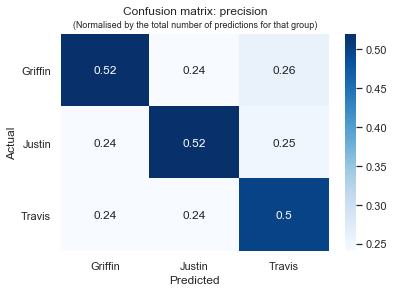

In [15]:
#Confusion matrix[i,j]: number of obs. known to be in group i but predicted to be in group j

#Based on "precision": how many of the predicted values for a group were actually correct

mat = np.round(confusion_matrix(ytest, y_model1, normalize="pred"), 2) #set normalize="pred" or None (or "true")
labels = ["Griffin", "Justin", "Travis"]

fig, ax = plt.subplots()
sns.heatmap(mat, cmap="Blues", annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")


#If normalize="pred"
ax.text(x=.7, y=-0.27, s="Confusion matrix: precision")
ax.text(x=0.14, y=-0.1, s="(Normalised by the total number of predictions for that group)", fontsize=9)

plt.yticks(rotation=0)

(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

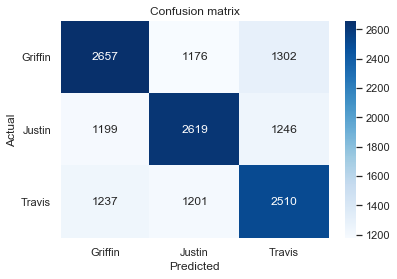

In [16]:
#Confusion matrix[i,j]: number of obs. known to be in group i but predicted to be in group j

#Based on "accuracy": overall proportion of correct predictions
#This isn't the best measure, because the dataset is unbalanced. (Just guessing "Justin" more often will increase accuracy.)

mat = np.round(confusion_matrix(ytest, y_model1, normalize=None), 2) #set normalize="pred" or None (or "true")
labels = ["Griffin", "Justin", "Travis"]

fig, ax = plt.subplots()
sns.heatmap(mat, cmap="Blues", annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

#If normalize=None
plt.title("Confusion matrix")

plt.yticks(rotation=0)

### 2.3 Results

We start by noting that the "support" column in the classification report shows the number of samples for each class. We see that there's a very slight imbalance still, but it's not as pronounced as the original dataset. 

We've also decided to show a "normalised" confused matrix — that's based on precision — as well as one with just the absolute numbers. A good way to think about the normalised confusion matrix is
>Looking at the vertical columns, we can ask: out of all the samples that were predicted to be "Travis" (for example), what proportion were classified as ___? And so, we expect the sum of numbers over each column to be equal to one.

The reason for this is two-fold. First, the absolute numbers aren't really the easiest to understand at first glance. Second, the precision gives us an idea of how good a job the model is doing predicting the different classes — regardless of the level of balance/imbalance in the dataset.

(The classification report shows the results for precision, recall, and the f1-score too.)

Our first pass at the model turned out pretty well, giving us a 51% test-set accuracy. This is clearly better than something guessing at "random" — which would have a ~33% success rate! We will also explore later, the kinds of samples it gets wrong. That will help us understand what the model struggles with.

While text-classification models can obviously do much better than this, we also need to keep in mind that our model is only classifying text into one class out of three people. This is a lot tougher than, say, classifying text into different news groups. After all, most people don't have *incredibly* different styles of speaking, and it's quite tough to confidently guess who said what. This is something we'll look into a bit more deeply later on.

Regardless, our first model is now done — we now move on to looking at different algorithms, and seeing if they fare better.

## 3. Model selection

### 3.1 Method

Now that we have some idea as to how our data looks and behaves, we can try and see if any other models work better.

We compare three models: Multinomial Naive Bayes, Linear Support-Vector Classification (SVC), and Logistic Regression.

For each one, we split the dataset into five cross-validation "folds", and get five different estimates of the accuracy for each model. (We can then visualize them using boxplots to get a better picture.)

Another important thing to note is that we're now getting the TFIDF vectorizer to count both unigrams and bigrams — meaning it should recognize words that usually come together. (This also provides a slight increase in accuracy.)

In [17]:
#Comparison of algorithms: trying out different models

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [("MultinomialNB", MultinomialNB()), 
("Linear SVC", LinearSVC(random_state=7)), 
("Logistic Regression", LogisticRegression(random_state=7))]

results = []
names = []

for name, m in models:
    
    model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), m) #look for both unigrams and bigrams
    
    #Split training set into 5 (=cv) and compute 5 different accuracies
    cv_results = cross_val_score(model, X, y, cv=5, scoring="accuracy") #create cv "folds", and evaluate accuracy
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

MultinomialNB: 0.544457 (0.002357)
Linear SVC: 0.553766 (0.003134)
Logistic Regression: 0.554789 (0.002101)


Text(0, 0.5, 'Accuracy')

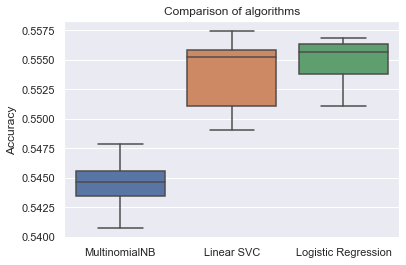

In [18]:
#Compare the different algorithms
sns.boxplot(names, results)
plt.title("Comparison of algorithms")
plt.ylabel("Accuracy")

### 3.2 Results

We see that the three models all fare pretty similarly, hovering around 55% accuracy. (Again, accuracy may not be the best metric, but at the moment, we're just trying to get an idea of the different models.) The two new models perform slightly better than our first pass, but the difference isn't that significant.

We then choose the logistic-regression model, and continue building on it.

## 4. Model evaluation: logistic regression

We then fit the training data to our logistic-regression model, and analyse its performance on the test set — similarly to how we did for our first MultinomialNB model.

In [19]:
#Choose best model:
#Logistic regression

from sklearn.linear_model import LogisticRegression

model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression(random_state=7)) #look for both unigrams and bigrams

model.fit(Xtrain, ytrain)
ymodel = model.predict(Xtest)

In [20]:
#Logistic-regression accuracy
print(accuracy_score(ytest, ymodel))

0.5499438832772167


In [21]:
pd.DataFrame(classification_report(ytest, ymodel, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
Griffin,0.55,0.53,0.54,5135.00
Justin,0.54,0.61,0.57,5064.00
Travis,0.57,0.51,0.54,4948.00
accuracy,0.55,0.55,0.55,0.55
macro avg,0.55,0.55,0.55,15147.00
weighted avg,0.55,0.55,0.55,15147.00


(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

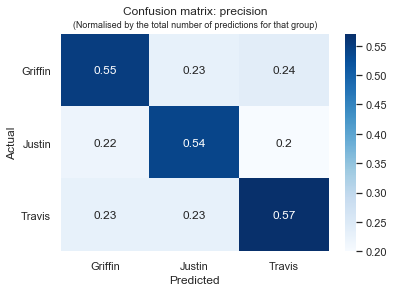

In [22]:
#Confusion matrix[i,j]: number of obs. known to be in group i but predicted to be in group j

#Based on "precision": how many of the predicted values for a group were actually correct

mat = np.round(confusion_matrix(ytest, ymodel, normalize="pred"), 2) #set normalize="pred" or None (or "true")
labels = ["Griffin", "Justin", "Travis"]

fig, ax = plt.subplots()
sns.heatmap(mat, cmap="Blues", annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

#If normalize="pred"
ax.text(x=.7, y=-0.27, s="Confusion matrix: precision")
ax.text(x=0.14, y=-0.1, s="(Normalised by the total number of predictions for that group)", fontsize=9)

plt.yticks(rotation=0)

(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

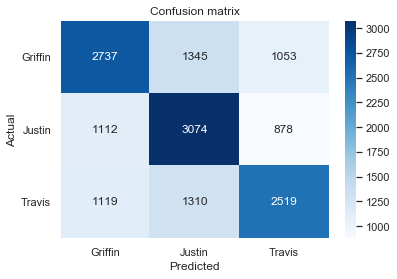

In [23]:
#Confusion matrix[i,j]: number of obs. known to be in group i but predicted to be in group j

#Based on "accuracy": overall proportion of correct predictions
#This isn't the best measure, because the dataset is unbalanced. (Just guessing "Justin" more often will increase accuracy.)

mat = np.round(confusion_matrix(ytest, ymodel, normalize=None), 2) #set normalize="pred" or None (or "true")
labels = ["Griffin", "Justin", "Travis"]

fig, ax = plt.subplots()
sns.heatmap(mat, cmap="Blues", annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

#If normalize=None
plt.title("Confusion matrix")

plt.yticks(rotation=0)

### 4.1 Results

We obtained an accuracy of about 55%, which is — despite obviously not being a *spectacular* text-classification accuracy score — pretty impressive, considering our dataset and how similar it all is! The categories (of three speakers) are fairly vague and similar in and of themselves, and there's really not all that much that can set aside one speaker from another.

Due to the slightly skewed classes, we should also keep an eye on the precision, recall, and f1-score values for our model. They all do fairly well. We can see that Justin has a particularly high recall value — this could be due to him having a slightly more distictive style of speaking!

We again note how the normalised precision-based confusion matrix provides a better measure of performance. We also see that the model doesn't seem to get particularly confused between any two pairs of speakers, but is fairly split amongst the misclassified cases.

In [94]:
#Learning curve (takes a bit of time to run)

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, scoring="f1_weighted")

In [95]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

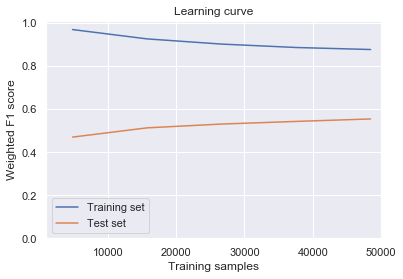

In [136]:
plt.plot(train_sizes, train_scores_mean, label="Training set")
plt.plot(train_sizes, test_scores_mean, label="Test set")
plt.title("Learning curve")
plt.ylabel("Weighted F1 score")
plt.xlabel("Training samples")
plt.xlim(3000, 50000)
plt.ylim(0,1.01)
plt.legend(frameon=True)

### 4.2 Learning curve

To evaluate our model and examine its potential bias/variance, we also plot a "learning curve", which shows us the evaluation metric as a function of training-set size — for both the training and test sets.

We can see the clear signs of *overfitting* in our model: the test score increases with training-set size, while the training score decreases — and there is a big gap between them. So, our model turn out to be a *high-variance* model. In many ways, this is to be expected, as our model has a large number of features — all the different words that the TFIDF vectorizer picked out! 

Common solutions to the problem of overfitting are: regularization (which our logistic-regression model is already doing), and getting more training samples (which I did after the first time I ran the model — increasing the dataset from 30 to 70 episodes). Another possible way to improve the model is by using some natural-language processing techniques like *stemming*, to help us reduce the complexity and number of features. 

The values also show that the problem our model is trying to work on — classifying text into one of three speakers — is quite a tough one and it can't keep getting more and more accurate. (This makes sense, as even a human couldn't read a piece of text and always confidently predict who said it!)

### 4.3 Misclassified data

Now that we have our model going, we can take a closer look at the kind of examples it gets wrong. This should help us get a better idea of what it's actually looking for. 

We display ten random samples that were misclassified, and also show the model's guess vs the actual speaker. This obviously brings to light how similar a lot of the text is and in fact, makes the 55% accuracy score even more impressive! 

This is also a good way to explore ways to better tune the model. On the first time running the model, I noticed that most of the misclassifications were small words, like "or", "sure", "yeah", etc. This was clearly an artefact due to the dataset containing lots of short "lines" like those. And the shorter words have a higher chance of being said equally by any of the three. 

This led me to put a minimum-string-length condition on the dataset, and led to higher test-set accuracy. Of course, the TFIDF vectorizer splits lines into separate words anyway, but the additional "short lines" weren't helping particularly with the training or testing.

We can also see some interesting patterns emerging. For example, most samples with mentions of food or drink are classified to Justin — and this is completely consistent with his personality. Also, most samples containing swears are classified to Griffin, which also makes sense, as he has a tendency to swear a lot more than the other two. (This can also be seen in the data-analysis notebook, *McElroy Analysis.ipynb*.) In fact, I'd probably guess a lot of the samples that same way the model did!

In [99]:
#Find misclassifications
#(Discrepancy between ymodel and ytest for particular indices)

ytest_index = ytest.reset_index(drop=True)
Xtest_index = Xtest.reset_index(drop=True)

mc = np.where(ytest_index != ymodel)[0] #indices of misclassifications

In [111]:
misclassify = pd.DataFrame(columns=["Line", "Guess", "Correct"])

#Put first 500 misclassifications into a DataFrame
for i in mc[0:500]:
    misclassify = misclassify.append({"Line": Xtest_index[i], "Guess": ymodel[i], "Correct": ytest_index[i]}, ignore_index=True)

In [121]:
#View examples of misclassified text
#This can help us understand the kinds of things the algorithm is getting wrong, and how we can improve it

pd.set_option('display.max_colwidth', 150)

#Display random selection of misclassifications
misclassify.sample(n=10)

,Line,Guess,Correct
422,they say no you told us specifically not to do that its like huh well i,Travis,Justin
307,do you mean literally like if i pull the shell off of a snail does it,Griffin,Travis
268,they will continue making hamburgers though so do not fear,Justin,Travis
167,cause lets be honest weve gotten so big were big shots as,Griffin,Travis
266,if you guys were teachers what subject would you teach,Travis,Justin
141,youre walking it to the park just be like other mouses look at this idiot,Griffin,Justin
252,do you think at that point the goat and the cow and the horse got,Justin,Travis
235,there was like a curfew so we couldnt do it but still hey listen,Travis,Justin
208,8:45 to nine made oatmeal 9:01 realized burned oatmeal,Justin,Travis
193,also want to tell you about squarespace squarespace is a really cool way to,Travis,Griffin


In [122]:
#Try out your own text!

text = ["""
welcome to my brother my brother and me
"""]

p = model.predict_proba(text)[0]

print("Entry: " + text[0])

print("Griffin: " + str(np.round(p[0]*100, 2)))
print("Justin: " + str(np.round(p[1]*100, 2)))
print("Travis: " + str(np.round(p[2]*100, 2)))

Entry: 
welcome to my brother my brother and me

Griffin: 3.64
Justin: 80.96
Travis: 15.39


## 5. Conclusions

The text-prediction model turned out to be a really fun and interesting project — right from obtaining and cleaning the text from the transcripts, to transforming and exporting the data into a clean and usable format, to finding patterns via a preliminary analysis and finally, our machine-learning model. It provided a view into the power of these different algorithms, framed in the context of a simple comedy podcast that I've been listening to for so long!

Through the process, we also ended up gaining a lot of insights into the sorts of things that our model was looking for, as well as ways to improve it. Obviously, it's important that we stay aware of the limitations of this project — namely, how tough it is to accurately place pieces of text into these three (relatively) very similar categories. 

It also gave us an idea of the strengths of these text-classification methods, and how they can add value to many real-world systems. The important thing to notice is that a lot of the principles involved in the analysis are fairly similar. If the classes that we'd like to place different pieces of text in are sufficiently unique — like classifying spam emails, or placing news articles into different categories — we can imagine the model doing even better!